In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import TensorBoard

In [ ]:
# Khai báo các thông số
img_width, img_height = 224, 224
batch_size = 16
epochs = 10
num_classes = 3

In [ ]:
# Đường dẫn đến thư mục chứa dữ liệu
data_dir = '/content/drive/MyDrive/Colab Notebooks/Experimental/rmbg_dataset/0.5'

# Danh sách các lớp (classes) là các thư mục con trong thư mục chứa dữ liệu
classes = os.listdir(data_dir)
print(classes)

['arm', 'torso', 'leg']


In [ ]:
# Tạo empty lists để lưu trữ đường dẫn hình ảnh và nhãn tương ứng
image_paths = []
labels = []

# Lặp qua mỗi lớp
for class_label in classes:
  class_dir = os.path.join(data_dir, class_label)
  # Lặp qua mỗi hình ảnh trong mỗi lớp
  for image_name in os.listdir(class_dir):
    image_path = os.path.join(class_dir, image_name)
    image_paths.append(image_path)
    labels.append(class_label)

# Chia dữ liệu thành tập huấn luyện và tập validation
train_image_paths, val_image_paths, train_labels, val_labels = train_test_split(image_paths, labels, test_size=0.2, random_state=42)

# Tạo DataFrame cho tập huấn luyện
train_dataframe = pd.DataFrame({'image_path': train_image_paths, 'label': train_labels})
# Tạo DataFrame cho tập validation
val_dataframe = pd.DataFrame({'image_path': val_image_paths, 'label': val_labels})

In [ ]:
# Tạo ImageDataGenerator cho tập huấn luyện
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Chuẩn hóa lại giá trị pixel về khoảng [0,1]
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Tạo ImageDataGenerator cho tập validation, chỉ cần rescale lại giá trị pixel
val_datagen = ImageDataGenerator(rescale=1./255)

# Tạo generator cho tập huấn luyện
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_dataframe,  # DataFrame chứa đường dẫn hình ảnh và nhãn cho tập huấn luyện
    x_col="image_path",
    y_col="label",
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

# Tạo generator cho tập validation
validation_generator = val_datagen.flow_from_dataframe(
    dataframe=val_dataframe,  # DataFrame chứa đường dẫn hình ảnh và nhãn cho tập validation
    x_col="image_path",
    y_col="label",
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 84 validated image filenames belonging to 3 classes.
Found 21 validated image filenames belonging to 3 classes.


In [ ]:
print(train_generator.samples, validation_generator.samples)

84 21


In [ ]:
# Load pre-trained VGG19 model without top layer
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

80134624/80134624 [==============================] - 1s 0us/step


In [ ]:
# Add custom layers
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

In [ ]:
# Freeze convolutional base
base_model.trainable = False

In [ ]:
# Compile model
model.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

In [ ]:
# Định nghĩa callback để ghi log TensorBoard
log_dir = "/content/drive/MyDrive/Colab Notebooks/Experimental/VGG19/logs/fit"
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [ ]:
# Train the model
history = model.fit(train_generator,
                    steps_per_epoch=train_generator.samples // batch_size,
                    epochs=epochs,
                    validation_data=validation_generator,
                    validation_steps=validation_generator.samples // batch_size,
                    callbacks=[tensorboard_callback])

Epoch 1/10
5/5 [==============================] - 34s 6s/step - loss: 6.7902 - accuracy: 0.2500 - val_loss: 2.9099 - val_accuracy: 0.7500
Epoch 2/10
5/5 [==============================] - 7s 2s/step - loss: 4.2851 - accuracy: 0.5294 - val_loss: 2.5349 - val_accuracy: 0.6250
Epoch 3/10
5/5 [==============================] - 8s 2s/step - loss: 1.8599 - accuracy: 0.7353 - val_loss: 0.1749 - val_accuracy: 0.9375
Epoch 4/10
5/5 [==============================] - 7s 2s/step - loss: 0.9898 - accuracy: 0.6765 - val_loss: 0.0977 - val_accuracy: 1.0000
Epoch 5/10
5/5 [==============================] - 7s 2s/step - loss: 0.0985 - accuracy: 0.9375 - val_loss: 0.0194 - val_accuracy: 1.0000
Epoch 6/10
5/5 [==============================] - 8s 2s/step - loss: 0.1058 - accuracy: 0.9750 - val_loss: 0.0252 - val_accuracy: 1.0000
Epoch 7/10
5/5 [==============================] - 8s 2s/step - loss: 0.1455 - accuracy: 0.9559 - val_loss: 0.1888 - val_accuracy: 0.9375
Epoch 8/10
5/5 [========================

In [ ]:
# Evaluate the model
test_loss, test_acc = model.evaluate(validation_generator, steps=validation_generator.samples // batch_size)
print('Test accuracy:', test_acc)

1/1 [==============================] - 0s 237ms/step - loss: 0.0410 - accuracy: 1.0000
Test accuracy: 1.0


In [ ]:
image_path = '/content/drive/MyDrive/Colab Notebooks/Experimental/test_image.jpg'
img = load_img(image_path, target_size=(img_width, img_height))
img_array = img_to_array(img)

# Rescale hình ảnh
img_array /= 255.
img_array = img_array.reshape(1, 224, 224, 3)
img_array.shape

In [ ]:
model.predict(img_array)

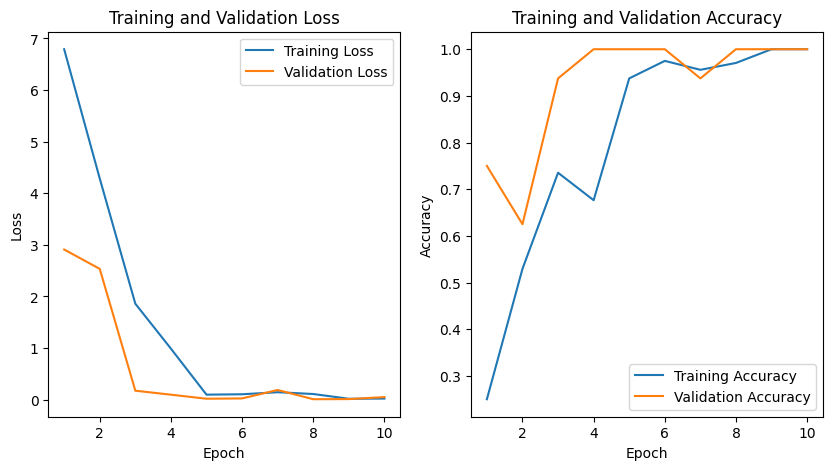

In [ ]:
# Lấy thông tin về loss và accuracy từ history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs_range = range(1, epochs+1)

# Vẽ biểu đồ loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Vẽ biểu đồ accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.show()